In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import the training set
Trainset = pd.read_csv('Kickstarter_Train.csv')
Seed = 42

# Preprocessing of the data

In [3]:
# There are only a few useful parameters we can pass to our prediction algorithms
Trainset = Trainset[['blurb_length', 'category', 'converted_goal_amount',
                     'name_length', 'days_total', 'days_until_launch', 'state']]

In [4]:
# Hot-one-encoding of the category parameter
category_dummies = pd.get_dummies(Trainset['category'], drop_first=True)

# Put them together and drop the original category column
Trainset = pd.concat([Trainset, category_dummies], axis=1)
Trainset.drop('category', axis=1, inplace=True)

#### There is a lot of data, so another split into train and test can be performed.

In [5]:
# Split the set into X and y
from sklearn.model_selection import train_test_split
X = Trainset.drop('state', axis=1)
y = Trainset.state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#### RobustScaler is used as it is more sensitive towards outliers, which are present in the data

In [6]:
# Import RobustScaler
from sklearn.preprocessing import RobustScaler

# Apply Scaling
features = ['blurb_length', 'converted_goal_amount', 'name_length', 'days_total', 'days_until_launch']
transformer = RobustScaler().fit(X[features])
X[features] = transformer.transform(X[features])

# Models

All Models (except baseline) will be trained and predicted on the trainset. Afterwards the testset will be predicted.  
Finally the prediction will be done for the validation set, which at this point is not imported.

In [46]:
# Import models and other needed modules
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score

#### The focus is on recall, so a scorer is needed for later use in cross-validation

In [8]:
# Define scorer
scorer = make_scorer(recall_score)

## Baseline

This is a baseline model, which can be used to compare the models against. 

---------------------------------------------------------
[[    0 47146]
 [    0 66074]]
---------------------------------------------------------


/Users/christoph/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     47146
           1       0.58      1.00      0.74     66074

    accuracy                           0.58    113220
   macro avg       0.29      0.50      0.37    113220
weighted avg       0.34      0.58      0.43    113220

---------------------------------------------------------
Recall score: 1.0
---------------------------------------------------------
PR-AUC score: 0.79
---------------------------------------------------------
PR-Curve
0.583589471824766


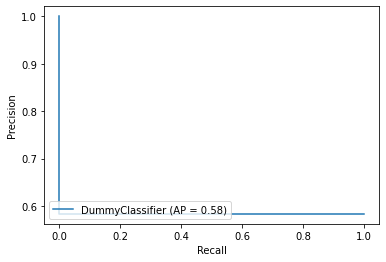

In [51]:
# Define model
dummy_clf = DummyClassifier(strategy="most_frequent")

# Fit on the data
dummy_clf.fit(X_train, y_train)

# Predict the target value
y_pred_dummy = dummy_clf.predict(X_train)

# Print the confusion matrix and classification report
print('---------------------------------------------------------')
print(confusion_matrix(y_train, y_pred_dummy))
print('---------------------------------------------------------')
print(classification_report(y_train, y_pred_dummy))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_train, y_pred_dummy)}')

# Calculate probability and precision/recall-auc-score
y_proba = dummy_clf.predict_proba(X_train)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_train, pos_probs)

# Print evaluation metrics
print('---------------------------------------------------------')
print(f'PR-AUC score: {auc(recall, precision).round(2)}')
print('---------------------------------------------------------')
print('PR-Curve')
# Plot PR-Curve
plot_precision_recall_curve(dummy_clf, X_train, y_train);
print(average_precision_score(y_train,y_pred_dummy))

As we can see, there is a small imbalance between the two classes: 58/42 %.  
The Recall-Score is 1 because there are no false negatives.   

## KNN

K-nearest neighbor will be the first used model

### Trainset

Fit and predict on the trainset

In [66]:
# Define model and parameters for RandomizedSearchCV
knn = KNeighborsClassifier(weights='uniform')
param_dist_knn = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
                 }

# Run RandomizedSearchCV
knn_best = RandomizedSearchCV(knn, param_dist_knn, verbose=1, n_jobs=-1, scoring=scorer, random_state=Seed, cv=3)
knn_best.fit(X_train, y_train)

# Print the best parameters
print('Best parameters for KNN')
print('---------------')
for pair in knn_best.best_params_.items():
    print(f'{pair[0].capitalize()} : {pair[1]}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   49.7s finished


Best parameters for KNN
---------------
N_neighbors : 19


In [67]:
# Use the best parameters 
knn = knn_best.best_estimator_

# Fit on the traindata
knn.fit(X_train, y_train)

# Predict the target value
y_pred_knn = knn.predict(X_train)

# Print evaluation metrics
print('---------------------------------------------------------')
print(confusion_matrix(y_train, y_pred_knn))
print('---------------------------------------------------------')
print(classification_report(y_train, y_pred_knn))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_train, y_pred_knn)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(knn, X_train, y_train, cv=5, scorer=scoring)}')

---------------------------------------------------------
[[23806 23340]
 [10170 55904]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.50      0.59     47146
           1       0.71      0.85      0.77     66074

    accuracy                           0.70    113220
   macro avg       0.70      0.68      0.68    113220
weighted avg       0.70      0.70      0.69    113220

---------------------------------------------------------
Recall score: 0.8460816660108363
---------------------------------------------------------
Cross validation scores: [0.66684331 0.67178944 0.66799152 0.66322205 0.66710828 0.67267267
 0.66763823 0.67505741 0.66216216 0.66083731]


PR-AUC-Score: 0.8


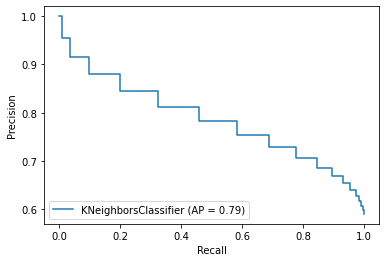

In [68]:
# Calculate probability and precision/recall-auc-score
y_proba = knn.predict_proba(X_train)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_train, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision).round(2)}')

# Plot PR-Curve
plot_precision_recall_curve(knn, X_train, y_train);

The Recall score on the trainset is 0.85 which is not bad for our purposes.  
The Curve also looks promising with a good score of 0.8.

### Testset

Predict the testset

In [43]:
# Predict the Testset
y_pred_knn_test = knn.predict(X_test)

# Print evaluation metrics
print(confusion_matrix(y_test, y_pred_knn_test))
print('---------------------------------------------------------')
print(classification_report(y_test, y_pred_knn_test))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_test, y_pred_knn_test)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(knn, X_test, y_test, cv=5, scoring=scorer)}')

[[ 6540  9175]
 [ 3216 18809]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.67      0.42      0.51     15715
           1       0.67      0.85      0.75     22025

    accuracy                           0.67     37740
   macro avg       0.67      0.64      0.63     37740
weighted avg       0.67      0.67      0.65     37740

---------------------------------------------------------
Recall score: 0.8539841089670829
---------------------------------------------------------
Cross validation scores: [0.85720772 0.85062429 0.85085131 0.8476731  0.85062429]


PR-AUC-Score: 0.74


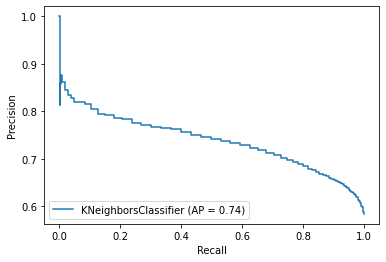

In [44]:
# Calculate probability and precision/recall-auc-score
y_proba = knn.predict_proba(X_test)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_test, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision).round(2)}')

# Plot PR-Curve
plot_precision_recall_curve(knn, X_test, y_test);

KNN still reaches a good Recall score of 0.81.  
The Curve score dropped to 0.73.

## Decision Tree Classifier

### Trainset

In [15]:
# Define model and parameters for GridSearch
tree = DecisionTreeClassifier(random_state=Seed, class_weight='balanced')
param_dist_tree = {'criterion' : ['gini', 'entropy'],
                  'max_depth' : [5,10,15,20,25,30],
                  'max_features' : ['sqrt', 'log2', None]
                  }

# Run GridSearch
tree_best = GridSearchCV(tree, param_dist_tree, scoring=scorer, cv=3, n_jobs=-1, verbose=1)
tree_best.fit(X_train, y_train)

# Print the best paramaters
print('Best parameters for DecionsTreeClassifier')
print('---------------')
for pair in tree_best.best_params_.items():
    print(f'{pair[0].capitalize()} : {pair[1]}')

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.0s


Best parameters for DecionsTreeClassifier
---------------
Criterion : gini
Max_depth : 5
Max_features : sqrt


[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   10.9s finished


In [16]:
# Use the best parameters on the model
tree = tree_best.best_estimator_

# Fit on the data
tree.fit(X_train, y_train)

# Predict the target value
y_pred_tree = tree.predict(X_train)

# Print evaluation metrics
print(confusion_matrix(y_train, y_pred_tree))
print('---------------------------------------------------------')
print(classification_report(y_train, y_pred_tree))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_train, y_pred_tree)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(tree, X_train, y_train, cv=10, scoring=scorer)}')

[[23501 23645]
 [15699 50375]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.50      0.54     47146
           1       0.68      0.76      0.72     66074

    accuracy                           0.65    113220
   macro avg       0.64      0.63      0.63    113220
weighted avg       0.65      0.65      0.65    113220

---------------------------------------------------------
Recall score: 0.7624027605412114
---------------------------------------------------------
Cross validation scores: [0.76222189 0.77281671 0.80959588 0.75707583 0.75192977 0.76479491
 0.75605327 0.75060533 0.77133777 0.75680993]


PR-AUC-Score : 0.71


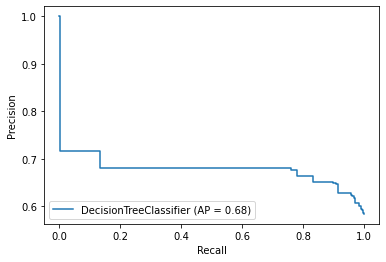

In [17]:
# Calculate probability and precision/recall-auc-score
y_proba = tree.predict_proba(X_train)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_train, pos_probs)

print(f'PR-AUC-Score : {auc(recall, precision).round(2)}')

# Plot PR-Curve
disp = plot_precision_recall_curve(tree, X_train, y_train);

The Recall score on the trainset is 0.76, which is worse then KNN.  
The Curve score is also worse with 0.71.
The best parameter of the tree only has a depth of 5, which is unexpected since a better result should be reached with more depth.

### Testset

In [18]:
# Testset
y_pred_tree_test = tree.predict(X_test)

# Print evaluation metrics
print(confusion_matrix(y_test, y_pred_tree_test))
print('---------------------------------------------------------')
print(classification_report(y_test, y_pred_tree_test))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_test, y_pred_tree_test)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(tree, X_test, y_test, cv=5, scoring=scorer)}')

[[ 7883  7832]
 [ 5167 16858]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.50      0.55     15715
           1       0.68      0.77      0.72     22025

    accuracy                           0.66     37740
   macro avg       0.64      0.63      0.63     37740
weighted avg       0.65      0.66      0.65     37740

---------------------------------------------------------
Recall score: 0.7654029511918274
---------------------------------------------------------
Cross validation scores: [0.78206583 0.76027242 0.74710556 0.78138479 0.7600454 ]


PR-AUC-Score: 0.71


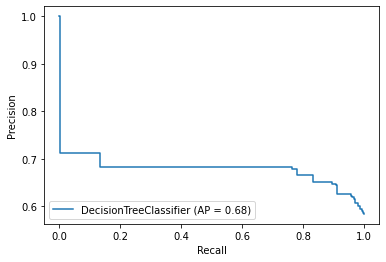

In [19]:
# Calculate probability and precision/recall-auc-score
y_proba = tree.predict_proba(X_test)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_test, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision).round(2)}')

# Plot PR-Curve
plot_precision_recall_curve(tree, X_test, y_test);

Recall and Curve score of the testset are identical to the trainset, which at least speaks for the models consistency.

## Logistic Regression

### Trainset

In [20]:
# Define model and parameters for GridSearch
lr = LogisticRegression(max_iter=1000, random_state=Seed, class_weight='balanced')
param_dist_lr = {'C' : [1,2,3,4,5,6,7,8,9,10]
                }

# Run GridSearch
lr_best = GridSearchCV(lr, param_dist_lr, scoring=scorer, cv=3)
lr_best.fit(X_train, y_train)

# Print the best parameters
print('Best parameters for LogisticRegression')
print('---------------')
for pair in lr_best.best_params_.items():
    print(f'{pair[0].capitalize()} : {pair[1]}')

Best parameters for LogisticRegression
---------------
C : 2


In [21]:
# Use the best parameters on the model
lr = lr_best.best_estimator_

# Fit on the data
lr.fit(X_train, y_train)

# Predict the target value
y_pred_lr_train = lr.predict(X_train)

# Print the confusion matrix and classification report
print(confusion_matrix(y_train, y_pred_lr_train))
print('---------------------------------------------------------')
print(classification_report(y_train, y_pred_lr_train))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_train, y_pred_lr_train)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(lr, X_train, y_train, cv=5, scoring=scorer)}')

[[26122 21024]
 [21775 44299]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.55      0.55     47146
           1       0.68      0.67      0.67     66074

    accuracy                           0.62    113220
   macro avg       0.61      0.61      0.61    113220
weighted avg       0.62      0.62      0.62    113220

---------------------------------------------------------
Recall score: 0.6704452583467022
---------------------------------------------------------
Cross validation scores: [0.67216588 0.68134695 0.66121831 0.6636398  0.67317442]


PR-AUC-Score: 0.69


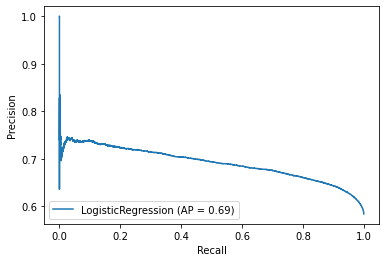

In [22]:
# Plot PR-Curve
y_proba = lr.predict_proba(X_train)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_train, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision).round(2)}')

# Print PR-Curve
disp = plot_precision_recall_curve(lr, X_train, y_train)

A Recall of 0.67 and the Curve score of 0.69 suggests that the logistic regressions tends to put more samples into the negative category.

### Testset

In [23]:
# Testset
y_pred_lr_test = lr.predict(X_test)

# Print evaluation metrics
print(confusion_matrix(y_test, y_pred_lr_test))
print('---------------------------------------------------------')
print(classification_report(y_test, y_pred_lr_test))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_test, y_pred_lr_test)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(lr, X_test, y_test, cv=5, scoring=scorer)}')

[[ 8773  6942]
 [ 7074 14951]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.55      0.56      0.56     15715
           1       0.68      0.68      0.68     22025

    accuracy                           0.63     37740
   macro avg       0.62      0.62      0.62     37740
weighted avg       0.63      0.63      0.63     37740

---------------------------------------------------------
Recall score: 0.6788195232690125
---------------------------------------------------------
Cross validation scores: [0.6599319  0.67786606 0.68036322 0.67219069 0.66992054]


PR-AUC-Score: 0.7


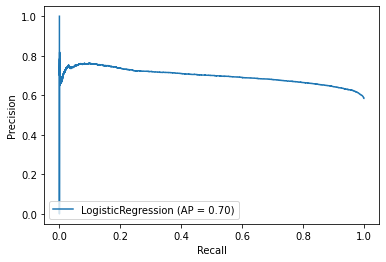

In [24]:
# Calculate probability and precision/recall-auc-score
y_proba = lr.predict_proba(X_test)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_test, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision).round(2)}')

# Plot PR-Curve
plot_precision_recall_curve(lr, X_test, y_test);

Scores for the testset and trainset are nearly identical making it a consistent model, much like the Decision tree.

## Random Forest

### Trainset

In [26]:
# Define model and parameters for RandomizedSearchCV
rf = RandomForestClassifier(random_state=Seed)
param_dist_rf = {'max_features' : ['sqrt', 'log2'],
                 'max_depth' : np.linspace(10, 110, num = 11).tolist() + [None],
                 'min_samples_split' : [5, 10, 15],
                 'min_samples_leaf' : [10,15,20],
                 'bootstrap' : [True, False],
                 'max_leaf_nodes' : [50,100],
                 'class_weight' : ['balanced', 'balanced_subsample']
                }

# Run RandomizedSearchCV
rf_best = RandomizedSearchCV(rf, param_dist_rf, n_iter = 100, cv = 3, scoring=scorer,
                               verbose=1, random_state=Seed, n_jobs = -1)
rf_best.fit(X_train, y_train)

# Print the best parameters
print('Best parameters for RandomForest')
print('---------------')
for pair in rf_best.best_params_.items():
    print(f'{pair[0].capitalize()} : {pair[1]}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.9min finished


Best parameters for RandomForest
---------------
Min_samples_split : 5
Min_samples_leaf : 15
Max_leaf_nodes : 100
Max_features : sqrt
Max_depth : 10.0
Class_weight : balanced_subsample
Bootstrap : False


In [27]:
# Use the best parameters on the model
rf = rf_best.best_estimator_

# Fit on the data
rf.fit(X_train, y_train)

# Predict the target value
y_pred_rf = rf.predict(X_train)

# Print the confusion matrix and classification report
# Print evaluation metrics
print(confusion_matrix(y_train, y_pred_rf))
print('---------------------------------------------------------')
print(classification_report(y_train, y_pred_rf))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_train, y_pred_rf)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(rf, X_train, y_train, cv=10, scoring=scorer)}')

[[30887 16259]
 [17761 48313]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.66      0.64     47146
           1       0.75      0.73      0.74     66074

    accuracy                           0.70    113220
   macro avg       0.69      0.69      0.69    113220
weighted avg       0.70      0.70      0.70    113220

---------------------------------------------------------
Recall score: 0.7311953264521597
---------------------------------------------------------
Cross validation scores: [0.71711821 0.73664295 0.73437264 0.73225367 0.72968064 0.73361586
 0.72321429 0.72260896 0.72911622 0.71973366]


PR-AUC-Score: 0.8


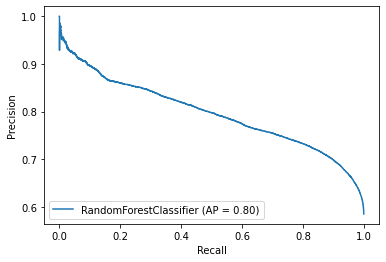

In [28]:
# Calculate probability and precision/recall-auc-score
y_proba = rf.predict_proba(X_train)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_train, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision).round(2)}')

# Plot PR-Curve
disp = plot_precision_recall_curve(rf, X_train, y_train)

The recall score is quite low with 0.73, but we have the highest curve score yet, which suggests a good balance between precision and recall.

### Testset

In [29]:
# Predict testset
y_pred_rf_test = rf.predict(X_test)

# Print evaluation metrics
print(confusion_matrix(y_test, y_pred_rf_test))
print('---------------------------------------------------------')
print(classification_report(y_test, y_pred_rf_test))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_test, y_pred_rf_test)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(rf, X_test, y_test, cv=10, scoring=scorer)}')

[[10339  5376]
 [ 5985 16040]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.66      0.65     15715
           1       0.75      0.73      0.74     22025

    accuracy                           0.70     37740
   macro avg       0.69      0.69      0.69     37740
weighted avg       0.70      0.70      0.70     37740

---------------------------------------------------------
Recall score: 0.7282633371169126
---------------------------------------------------------
Cross validation scores: [0.69450749 0.71856559 0.73490695 0.70403995 0.72764412 0.72479564
 0.7075386  0.71934605 0.72797457 0.73433243]


PR-AUC-Score: 0.79


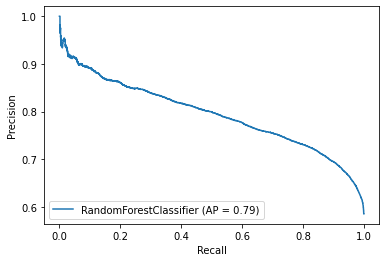

In [30]:
# Calculate probability and precision/recall-auc-score
y_proba = rf.predict_proba(X_test)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_test, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision).round(2)}')

# Plot PR-Curve
disp = plot_precision_recall_curve(rf, X_test, y_test)

Pretty much the same as the trainset.

# Model Validation on unused data

We now important the validation set and transform it in the same way as the trainset.

In [34]:
Val_data = pd.read_csv('Kickstarter_Validation.csv')
Val_data = Val_data[['blurb_length', 'category', 'converted_goal_amount',
            'name_length', 'days_total', 'days_until_launch', 'state']]

# Hot-one-encoding of the category parameter
category_dummies = pd.get_dummies(Val_data['category'], drop_first=True)

# Put them together and drop the original category column
Val_data = pd.concat([Val_data, category_dummies], axis=1)
Val_data.drop('category', axis=1, inplace=True)

# Split the set into X and y
X_val = Val_data.drop('state', axis=1)
y_val = Val_data.state

# Apply scaling from trainset
features = ['blurb_length', 'converted_goal_amount', 'name_length', 'days_total', 'days_until_launch']
X_val[features] = transformer.transform(X_val[features])

### Fit Models onto the validation set

[[    4 20950]
 [    0 29366]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.00      0.00     20954
           1       0.58      1.00      0.74     29366

    accuracy                           0.58     50320
   macro avg       0.79      0.50      0.37     50320
weighted avg       0.76      0.58      0.43     50320

---------------------------------------------------------
Recall score: 1.0
---------------------------------------------------------
Cross validation scores: [0.68111363 0.68252549 0.68413522]
PR-AUC-Score: 0.4867549971091235


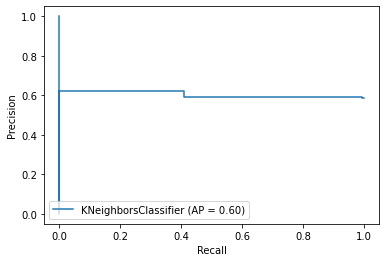

In [70]:
knn.fit(X_train, y_train)

# Predict the target value
y_pred_knn_val = knn.predict(X_val)

# Print the confusion matrix and classification report
print(confusion_matrix(y_val, y_pred_knn_val))
print('---------------------------------------------------------')
print(classification_report(y_val, y_pred_knn_val))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_val, y_pred_knn_val)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(knn, X_val, y_val, cv=3)}')

y_proba = knn.predict_proba(X_val)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_val, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision)}')

disp = plot_precision_recall_curve(knn, X_val, y_val)

KNN very obviously has a problem here. The Recall score is at 1 because the algorithm set nearly all predictions as positive. The curve score dropped below 0.5.  
It is clear that the KNN in this iteration doesn't seem to be an appropriate algorithm for the problem at hand.

[[ 6609 14345]
 [ 3900 25466]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.32      0.42     20954
           1       0.64      0.87      0.74     29366

    accuracy                           0.64     50320
   macro avg       0.63      0.59      0.58     50320
weighted avg       0.64      0.64      0.60     50320

---------------------------------------------------------
Recall score: 0.8671933528570456
---------------------------------------------------------
Cross validation scores: [0.74659401 0.73262943 0.73058583 0.73331063 0.72795369 0.71229145
 0.71739871 0.73748723 0.73272046 0.71842016]
PR-AUC-Score: 0.6964698757132932


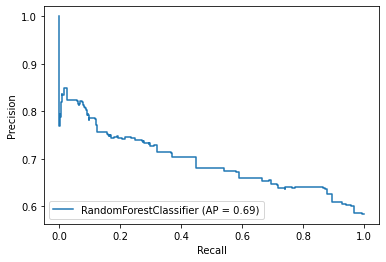

In [63]:
rf.fit(X_train, y_train)

# Predict the target value
y_pred_rf_test = rf.predict(X_val)

# Print the confusion matrix and classification report
print(confusion_matrix(y_val, y_pred_rf_test))
print('---------------------------------------------------------')
print(classification_report(y_val, y_pred_rf_test))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_val, y_pred_rf_test)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(rf, X_val, y_val, cv=10, scoring=scorer)}')

y_proba = rf.predict_proba(X_val)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_val, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision)}')
disp = plot_precision_recall_curve(rf, X_val, y_val)

The Random forest does really well with a recall score of 0.87 and a curve score of 0.7. This suggests a suiteable tradeoff between precision and recall for our purposes

[[ 5590 15364]
 [ 3428 25938]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.27      0.37     20954
           1       0.63      0.88      0.73     29366

    accuracy                           0.63     50320
   macro avg       0.62      0.58      0.55     50320
weighted avg       0.62      0.63      0.58     50320

---------------------------------------------------------
Recall score: 0.8832663624599877
---------------------------------------------------------
Cross validation scores: [0.78031335 0.76668937 0.75408719 0.75374659 0.76540688 0.75212802
 0.74804222 0.76949268 0.7504256  0.75314947]
PR-AUC-Score: 0.6718886546866298


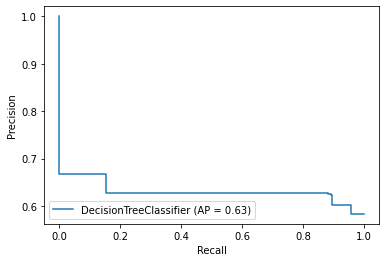

In [64]:
tree.fit(X_train, y_train)

# Predict the target value
y_pred_tree_val = tree.predict(X_val)

# Print the confusion matrix and classification report
print(confusion_matrix(y_val, y_pred_tree_val))
print('---------------------------------------------------------')
print(classification_report(y_val, y_pred_tree_val))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_val, y_pred_tree_val)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(tree, X_val, y_val, cv=10, scoring=scorer)}')

y_proba = tree.predict_proba(X_val)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_val, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision)}')
disp = plot_precision_recall_curve(tree, X_val, y_val)

Nearly as good as the random forest. The recall is better, but the curve score is lower. Since the Decision tree is a lot more cost effective, it might be the best algorithm at this point.

[[13104  7850]
 [14347 15019]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.63      0.54     20954
           1       0.66      0.51      0.58     29366

    accuracy                           0.56     50320
   macro avg       0.57      0.57      0.56     50320
weighted avg       0.58      0.56      0.56     50320

---------------------------------------------------------
Recall score: 0.5114418034461622
---------------------------------------------------------
Cross validation scores: [0.71321526 0.70776567 0.69346049 0.69346049 0.71229145 0.70616275
 0.6969697  0.72318693 0.70684372 0.69833163]
PR-AUC-Score: 0.6571925210798779


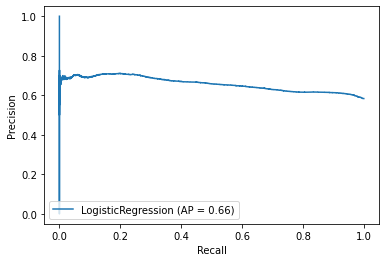

In [65]:
lr.fit(X_train, y_train)

# Predict the target value
y_pred_lr_val = lr.predict(X_val)

# Print the confusion matrix and classification report
print(confusion_matrix(y_val, y_pred_lr_val))
print('---------------------------------------------------------')
print(classification_report(y_val, y_pred_lr_val))
print('---------------------------------------------------------')
print(f'Recall score: {recall_score(y_val, y_pred_lr_val)}')
print('---------------------------------------------------------')
print(f'Cross validation scores: {cross_val_score(lr, X_val, y_val, cv=10, scoring=scorer)}')

y_proba = lr.predict_proba(X_val)
pos_probs = y_proba[:, 1]
precision, recall, _ = precision_recall_curve(y_val, pos_probs)

print(f'PR-AUC-Score: {auc(recall, precision)}')
disp = plot_precision_recall_curve(lr, X_val, y_val)

A Recall score of 0.51 is only slightly better then the KNN. The Curve score is a lot better at 0.65. But the moel as a whole is still unusable in comparison to the random forest and decision tree.